In [1]:
import pathlib
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from scipy import signal

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
# Download the file from Google Drive
!gdown --id 1obodFRGgoYjYGMj2MLGNfntEkQhwaS7g

# Unzip the downloaded file into the specified directory
!unzip voice_data.zip -d /content/

# Remove the zip file after extracting its contents
!rm -r voice_data.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1obodFRGgoYjYGMj2MLGNfntEkQhwaS7g
To: /content/voice_data.zip
100% 6.32M/6.32M [00:00<00:00, 64.8MB/s]
Archive:  voice_data.zip
   creating: /content/data/
  inflating: /content/__MACOSX/._data  
   creating: /content/data/green/
  inflating: /content/__MACOSX/data/._green  
  inflating: /content/data/.DS_Store  
  inflating: /content/__MACOSX/data/._.DS_Store  
   creating: /content/data/red/
  inflating: /content/__MACOSX/data/._red  
   creating: /content/data/on/
  inflating: /content/__MACOSX/data/._on  
   creating: /content/data/off/
  inflating: /content/__MACOSX/data/._off  
  inflating: /content/data/green/green_45.wav  
  inflating: /content/__MACOSX/data/green/._green_45.wav  
  inflating: /content/data/gr

Text(0.5, 1.0, 'Audio: Green')

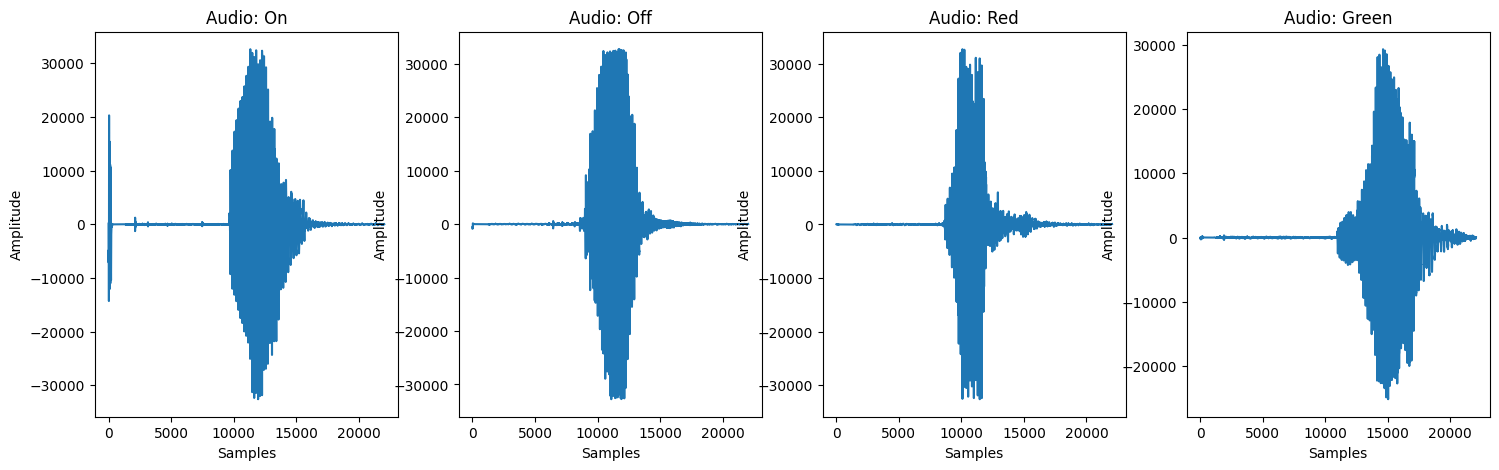

In [3]:
on_wav_file = read('/content/data/on/on_0.wav')
off_wav_file = read('/content/data/off/off_0.wav')
red_wav_file = read('/content/data/red/red_0.wav')
green_wav_file = read('/content/data/green/green_0.wav')

on_wav_file = on_wav_file[1]
off_wav_file = off_wav_file[1]
red_wav_file = red_wav_file[1]
green_wav_file = green_wav_file[1]

wavefile_plotter = plt.figure(figsize=(18, 5))
on_plot = wavefile_plotter.add_subplot(141)
off_plot = wavefile_plotter.add_subplot(142)
red_plot = wavefile_plotter.add_subplot(143)
green_plot = wavefile_plotter.add_subplot(144)

on_plot.plot(on_wav_file)
on_plot.set_xlabel('Samples')
on_plot.set_ylabel('Amplitude')
on_plot.set_title('Audio: On')

off_plot.plot(off_wav_file)
off_plot.set_xlabel('Samples')
off_plot.set_ylabel('Amplitude')
off_plot.set_title('Audio: Off')

red_plot.plot(red_wav_file)
red_plot.set_xlabel('Samples')
red_plot.set_ylabel('Amplitude')
red_plot.set_title('Audio: Red')

green_plot.plot(green_wav_file)
green_plot.set_xlabel('Samples')
green_plot.set_ylabel('Amplitude')
green_plot.set_title('Audio: Green')

In [115]:
data_dir = pathlib.Path('/content/data')
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
audio_files_with_path = tf.io.gfile.glob(str(data_dir) + '/*/*')

labels = np.delete(labels, 2)


In [116]:
labels

array(['off', 'on', 'red', 'green'], dtype='<U9')

In [119]:
# Filter out non-WAV files
wav_files = [file for file in audio_files_with_path if file.lower().endswith('.wav')]

# Convert the list to a NumPy array
audio_path_dataset = np.array(wav_files)

audio_path_dataset = tf.random.shuffle(audio_path_dataset)

In [120]:
len(audio_path_dataset)

200

In [121]:
wav_file_path = '/content/data/off/off_0.wav'
label = tf.strings.split(wav_file_path, os.path.sep)

label[-2]

wav_audio = tf.io.read_file(wav_file_path)
audio_tensor, sr = tf.audio.decode_wav(wav_audio)
audio_tensor = tf.squeeze(audio_tensor , axis = -1)
audio_tensor.shape


TensorShape([22050])

In [122]:
def path_to_labeled_tensor(file_path):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2]

    wav_audio = tf.io.read_file(file_path)
    audio_tensor, sr = tf.audio.decode_wav(wav_audio)
    audio_tensor = tf.squeeze(audio_tensor, axis=-1)
    return audio_tensor, label

data_tf_pipelines = tf.data.Dataset.from_tensor_slices(audio_path_dataset)
labeled_waveform_dataset = data_tf_pipelines.map(path_to_labeled_tensor)

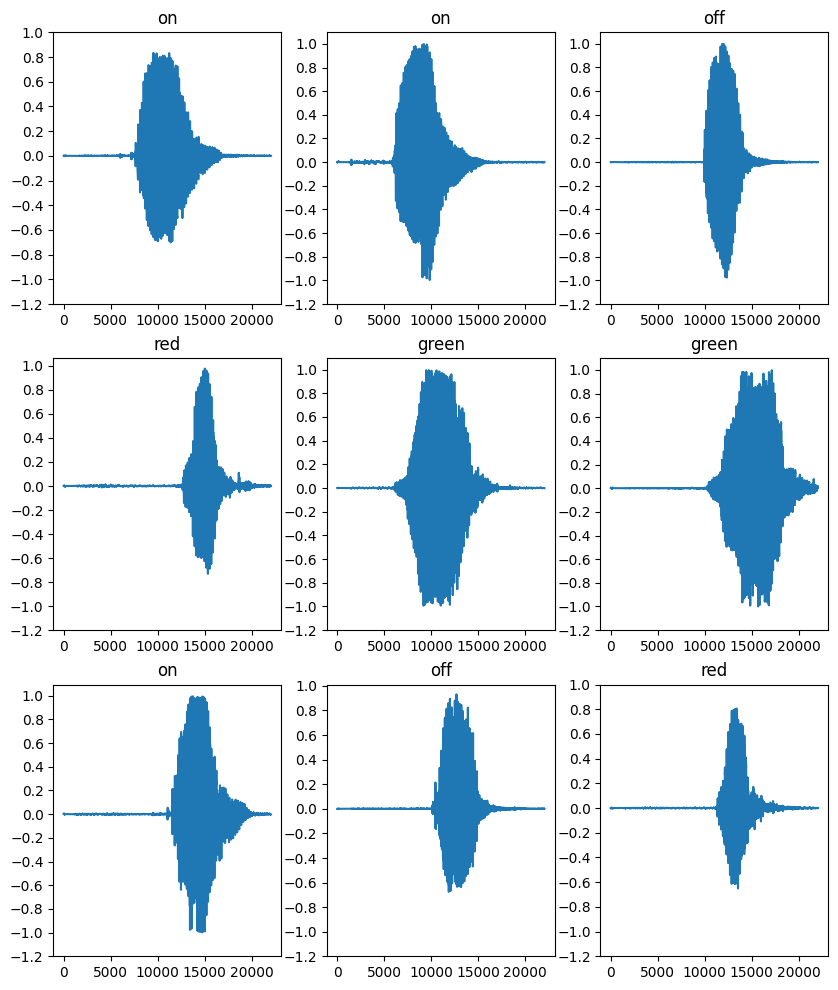

In [123]:
rows = 3
cols =3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(labeled_waveform_dataset.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# Spectrogram Conversion

In [124]:
for waveform , label in labeled_waveform_dataset.take(1):
  f,t,spectrogram = signal.stft(waveform.numpy() , fs = 22050)
  spectrogram = tf.convert_to_tensor(np.abs(spectrogram))

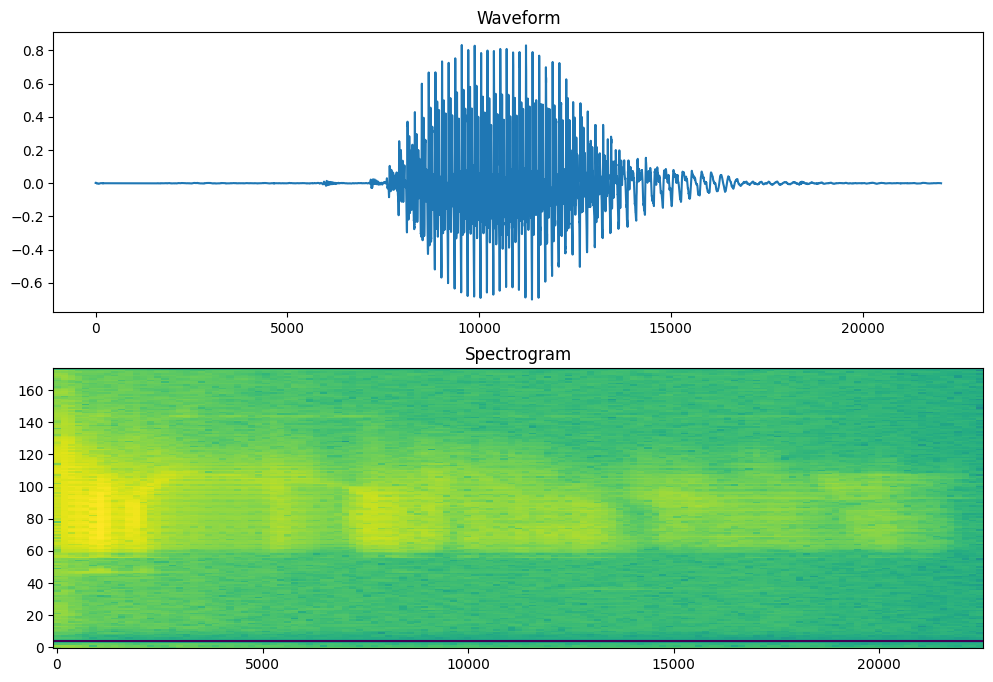

In [125]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

plt.show()

# Splitting Data

In [126]:
training_dataset = audio_path_dataset[:120]
validation_dataset = audio_path_dataset[121:160]
testing_dataset = audio_path_dataset[161:200]

len(audio_path_dataset)


200

In [127]:
def path_to_labeled_tensor(file_path):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2]
    wav_audio = tf.io.read_file(file_path)
    audio_tensor, _ = tf.audio.decode_wav(wav_audio)  # The second output is the sample rate
    audio_tensor = tf.squeeze(audio_tensor, axis=-1)
    return audio_tensor, label

def stft(waveform):
    f, t, spec = signal.stft(waveform.numpy(), fs=22050, nperseg=255, noverlap=124, nfft=256)
    return tf.convert_to_tensor(np.abs(spec))

def waveforms_to_spectrograms(waveform, label):
    spectrogram = tf.py_function(func=stft, inp=[waveform], Tout=tf.float32)
    spectrogram.set_shape((129,170))
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    label = tf.math.argmax(label==labels)
    return spectrogram, label

def raw_wavefile_path_to_Spectrogram(input_path_dataset):
    data_tf_pipelines = tf.data.Dataset.from_tensor_slices(input_path_dataset)
    labeled_waveform_dataset = data_tf_pipelines.map(path_to_labeled_tensor)
    spectrogram_labeled_dataset = labeled_waveform_dataset.map(waveforms_to_spectrograms)
    return spectrogram_labeled_dataset

training_ds = raw_wavefile_path_to_Spectrogram(audio_path_dataset)
testing_ds = raw_wavefile_path_to_Spectrogram(testing_dataset)
validation_ds = raw_wavefile_path_to_Spectrogram(validation_dataset)

In [128]:
len(training_ds)

200

In [129]:
training_ds

<_MapDataset element_spec=(TensorSpec(shape=(1, 129, 170), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [130]:
for waveform, label in training_ds.take(1):
  input_shape = waveform.shape

print("Input Shape ", input_shape)


Input Shape  (1, 129, 170)


# Building and Training Model

In [131]:
training_ds

<_MapDataset element_spec=(TensorSpec(shape=(1, 129, 170), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [132]:
num_batch = 2
train_data_batch = training_ds.batch(num_batch)
valid_data_batch = validation_ds.batch(num_batch)

In [133]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_data_batch.map(lambda x, _: x))

audio_led_model = models.Sequential()
audio_led_model.add(layers.Input(shape=input_shape))
audio_led_model.add(preprocessing.Resizing(32, 32))
audio_led_model.add(norm_layer)
audio_led_model.add(layers.Conv2D(32, 3, activation='relu'))
audio_led_model.add(layers.Conv2D(64, 3, activation='relu'))
audio_led_model.add(layers.MaxPooling2D())
audio_led_model.add(layers.Dropout(0.25))
audio_led_model.add(layers.Flatten())
audio_led_model.add(layers.Dense(128, activation='relu'))
audio_led_model.add(layers.Dropout(0.5))
audio_led_model.add(layers.Dense(len(labels)))

audio_led_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 170)       0         
                                                                 
 normalization_4 (Normaliza  (None, 32, 32, 170)       341       
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        48992     
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)       

In [134]:
audio_led_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [135]:
history_1 = audio_led_model.fit(train_data_batch, epochs=25, validation_data=valid_data_batch)

Epoch 1/25
100/100 [==============================] - 7s 60ms/step - loss: 1.4316 - accuracy: 0.5500 - val_loss: 1.5177 - val_accuracy: 0.6923
Epoch 2/25
100/100 [==============================] - 7s 74ms/step - loss: 1.0706 - accuracy: 0.7000 - val_loss: 1.0126 - val_accuracy: 0.6923
Epoch 3/25
100/100 [==============================] - 6s 63ms/step - loss: 1.1486 - accuracy: 0.7250 - val_loss: 0.2826 - val_accuracy: 0.8974
Epoch 4/25
100/100 [==============================] - 7s 66ms/step - loss: 1.2879 - accuracy: 0.7600 - val_loss: 0.4686 - val_accuracy: 0.7436
Epoch 5/25
100/100 [==============================] - 8s 77ms/step - loss: 0.6451 - accuracy: 0.8100 - val_loss: 0.2763 - val_accuracy: 0.8974
Epoch 6/25
100/100 [==============================] - 6s 58ms/step - loss: 0.5348 - accuracy: 0.8000 - val_loss: 0.5203 - val_accuracy: 0.8205
Epoch 7/25
100/100 [==============================] - 7s 69ms/step - loss: 0.4796 - accuracy: 0.8100 - val_loss: 0.2284 - val_accuracy: 0.8718

Text(0.5, 1.0, 'Model:1 B:2, Logits:True')

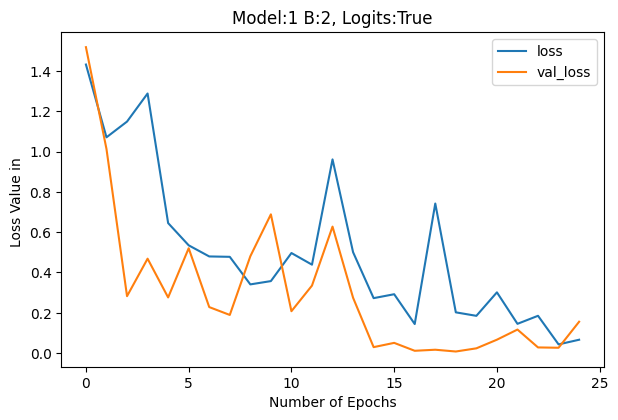

In [136]:
wavefile_plotter = plt.figure(figsize=(7, 20))
metrics_1 = wavefile_plotter.add_subplot(411)

metrics = history_1.history
metrics_1.plot(history_1.epoch, metrics['loss'], metrics['val_loss'])
metrics_1.legend(['loss', 'val_loss'])
metrics_1.set_xlabel('Number of Epochs')
metrics_1.set_ylabel('Loss Value in ')
metrics_1.set_title('Model:1 B:2, Logits:True')

# Making the Predictions

In [137]:
test_specs = []
testdata_labels= []
for spectrogram, label in testing_ds:
  test_specs.append(spectrogram.numpy())
  testdata_labels.append(label.numpy())

test_specs = np.array(test_specs)
test_labels = np.array(testdata_labels)

In [140]:
model_prediction = audio_led_model.predict(test_specs)
print("All labels: ", labels)
print("Model Predictions: ", model_prediction[16])
print("Actual Label: ", test_labels[16])
print("Prediction: ", np.argmax(model_prediction[16]))

2/2 [==============================] - 0s 46ms/step
All labels:  ['off' 'on' 'red' 'green']
Model Predictions:  [-58.32551  -57.61476   74.22209  -41.031605]
Actual Label:  2
Prediction:  2


In [138]:
model_predictions = np.argmax(audio_led_model.predict(test_specs), axis=1)
model_predictions

2/2 [==============================] - 0s 29ms/step


array([0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 3, 3, 1, 2, 2, 2, 3, 3, 3, 3,
       0, 1, 3, 3, 1, 0, 3, 1, 0, 0, 3, 2, 1, 1, 3, 3, 2])

In [139]:
test_labels

array([0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 3, 3, 1, 2, 2, 2, 3, 3, 3, 3,
       0, 1, 3, 3, 1, 0, 3, 1, 1, 0, 3, 2, 1, 1, 3, 3, 2])